# Explainable AI (XAI)

## What is it?

While the algorithms become more sophisticated, our human
ability to interpret internal workings decreases, and they perform as an algorithmic "black
box".

Explainable AI is the desire to enable machine learning systems to 
- provide a rationale of how they arrived at their decisions
- characterize their strength and weaknesses
- do so in ways that ensures societal, moral, and legal compliance
- do so in ways that are interpretable to humans 


## Why is it useful?


Is it trustworthy?

[<img src="resources/6/need_of_explanation.png" width="500"/>](resources/6/need_of_explanation.png)


Is it fair?

[<img src="resources/6/legislation.png" width="500"/>](resources/6/legislation.png)


Will it work in the wild?

[<img src="resources/6/nazi_chatbot.png" width="500"/>](resources/6/nazi_chatbot.png)


Why is it broken?

[<img src="resources/6/will_it_work_in_the_future.png" width="500"/>](resources/6/will_it_work_in_the_future.png)






## How?

### Interpretability

Use machine learners that are directly interpretable to humans. 

- Linear regression
- Decision trees
- Naive Bays
- Text embeddings and visualizations
- Use machine learners that provide explanations themselves

### Explainability

Use methods that models the cause (input) and effect (output) from complex models and who's result is interpretable to humans.

- Shapley-value based explanations
- LIME (Local Interpretable Model-agnostic Explanations)
- Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization


## Demonstration - 20 new group classification 

eli5 tutorial: https://eli5.readthedocs.io/en/latest/tutorials/sklearn-text.html

In [1]:
# Google colab only

!pip install eli5
!pip install jinja2==3.0.0

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']

twenty_train = fetch_20newsgroups(
    subset='train',
    categories=categories,
    shuffle=True,
    random_state=42
)

twenty_test = fetch_20newsgroups(
    subset='test',
    categories=categories,
    shuffle=True,
    random_state=42
)

In [21]:

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

vec = CountVectorizer()
clf = LogisticRegression(max_iter=200)
pipe = make_pipeline(vec, clf)
pipe.fit(twenty_train.data, twenty_train.target)

from sklearn import metrics

def print_report(pipe):
    y_test = twenty_test.target
    y_pred = pipe.predict(twenty_test.data)
    report = metrics.classification_report(y_test, y_pred,
        target_names=twenty_test.target_names)
    print(report)
    print("accuracy: {:0.3f}".format(metrics.accuracy_score(y_test, y_pred)))

print_report(pipe)

                        precision    recall  f1-score   support

           alt.atheism       0.80      0.76      0.78       319
         comp.graphics       0.81      0.93      0.86       389
               sci.med       0.86      0.77      0.81       396
soc.religion.christian       0.86      0.86      0.86       398

              accuracy                           0.83      1502
             macro avg       0.83      0.83      0.83      1502
          weighted avg       0.83      0.83      0.83      1502

accuracy: 0.832


We can inspect features and weights because we’re using a bag-of-words vectorizer and a linear classifier

In [22]:
import eli5

eli5.show_weights(clf, vec=vec, top=10, target_names=twenty_test.target_names)

In [23]:
import eli5

eli5.show_prediction(clf, twenty_test.data[0], vec=vec, target_names=twenty_test.target_names)

The model has picked up the headers in the emails. Lets remove them.

In [24]:
twenty_train = fetch_20newsgroups(
    subset='train',
    categories=categories,
    shuffle=True,
    random_state=42,
    remove=['headers', 'footers'],
)
twenty_test = fetch_20newsgroups(
    subset='test',
    categories=categories,
    shuffle=True,
    random_state=42,
    remove=['headers', 'footers'],
)

vec = CountVectorizer()
clf = LogisticRegression(max_iter=200)
pipe = make_pipeline(vec, clf)
pipe.fit(twenty_train.data, twenty_train.target);

In [25]:
import eli5

eli5.show_prediction(clf, twenty_test.data[0], vec=vec, target_names=twenty_test.target_names)

## Demonstration - Explaining Keras image classifier predictions with Grad-CAM

eli5 tutorial: https://eli5.readthedocs.io/en/latest/tutorials/keras-image-classifiers.html

Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization. https://arxiv.org/pdf/1610.02391.pdf

In [8]:
from PIL import Image
from IPython.display import display
import numpy as np

# you may want to keep logging enabled when doing your own work
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR) # disable Tensorflow warnings for this tutorial
tf.compat.v1.disable_eager_execution()

import warnings
warnings.simplefilter("ignore") # disable Keras warnings for this tutorial
import keras
from keras.applications import mobilenet_v2

import eli5

In [9]:
"""Load model"""
model = mobilenet_v2.MobileNetV2(include_top=True, weights='imagenet', classes=1000)

# check the input format
print(model.input_shape)
dims = model.input_shape[1:3] # -> (height, width)
print(dims)

(None, 224, 224, 3)
(224, 224)


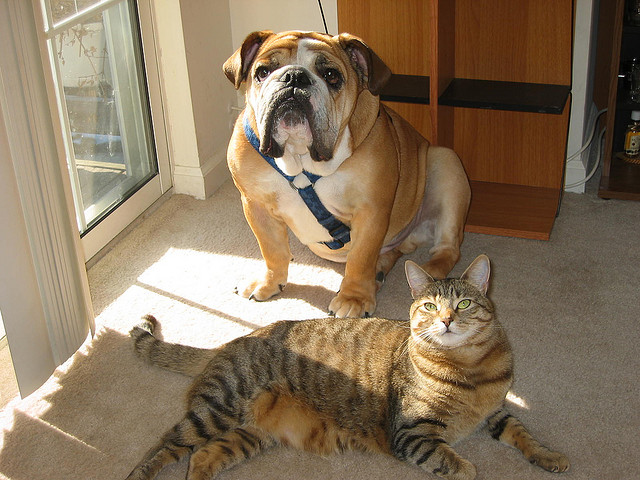

In [10]:
"""Load and resize image"""
image_uri = 'resources/6/friends.png'
im = Image.open(image_uri)
display(im)

In [11]:
im = keras.preprocessing.image.load_img(image_uri, target_size=dims)
doc = keras.preprocessing.image.img_to_array(im) # -> numpy array
doc = np.expand_dims(doc, axis=0)

mobilenet_v2.preprocess_input(doc)
predictions = model.predict(doc)

top = mobilenet_v2.decode_predictions(predictions)
top_indices = np.argsort(predictions)[0, ::-1][:5]

import pprint

print("Predictions:")
pp = pprint.PrettyPrinter(depth=4)
pp.pprint(top)

print("\nIndicies:")
pp.pprint(top_indices)

Predictions:
[[('n02108422', 'bull_mastiff', 0.80967504),
  ('n02108089', 'boxer', 0.09835995),
  ('n02123045', 'tabby', 0.0066503794),
  ('n02123159', 'tiger_cat', 0.004808713),
  ('n02110958', 'pug', 0.003940994)]]

Indicies:
array([243, 242, 281, 282, 254], dtype=int64)


Can we trust the "bull mastiff" prediction?

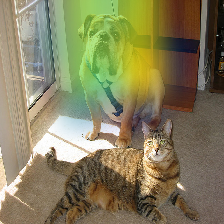

In [12]:
eli5.show_prediction(model, doc)

Why didn't the tiger cat result in a higher confidence?

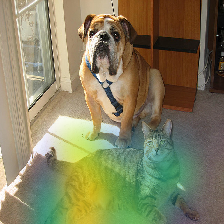

In [13]:
cat_idx = 282 # ImageNet ID for "tiger_cat" class, because we have a cat in the picture
eli5.show_prediction(model, doc, targets=[cat_idx]) # pass the class id

Why does the class "pug" has the fifth highest confidence?

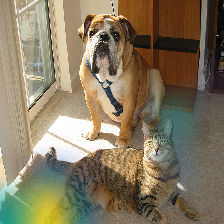

In [19]:
pug_idx = 254 # ImageNet ID for "pug" class, because we have a don't in the picture but it was the fifth highest prediction
eli5.show_prediction(model, doc, targets=[pug_idx]) # pass the class id

How about the window?

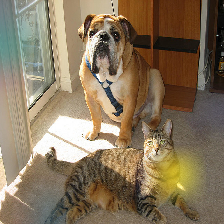

In [15]:
window_idx = 904 # 'window screen'
display(eli5.show_prediction(model, doc, targets=[window_idx]))

How about the layers? Do they make sense?

In [16]:
def pretty_print_layers(layers):
    for l in layers:
        info = [l.name, type(l).__name__, l.output_shape, l.count_params()]
        pretty_print(info)

def pretty_print(lst):
    s = ',\t'.join(map(str, lst))
    print(s)

pretty_print(['name', 'type', 'output shape', 'param. no'])
pretty_print([model.input.name, type(model.input), model.input_shape, 0])
pretty_print_layers(model.layers)

name,	type,	output shape,	param. no
input_1:0,	<class 'tensorflow.python.framework.ops.Tensor'>,	(None, 224, 224, 3),	0
input_1,	InputLayer,	[(None, 224, 224, 3)],	0
Conv1,	Conv2D,	(None, 112, 112, 32),	864
bn_Conv1,	BatchNormalization,	(None, 112, 112, 32),	128
Conv1_relu,	ReLU,	(None, 112, 112, 32),	0
expanded_conv_depthwise,	DepthwiseConv2D,	(None, 112, 112, 32),	288
expanded_conv_depthwise_BN,	BatchNormalization,	(None, 112, 112, 32),	128
expanded_conv_depthwise_relu,	ReLU,	(None, 112, 112, 32),	0
expanded_conv_project,	Conv2D,	(None, 112, 112, 16),	512
expanded_conv_project_BN,	BatchNormalization,	(None, 112, 112, 16),	64
block_1_expand,	Conv2D,	(None, 112, 112, 96),	1536
block_1_expand_BN,	BatchNormalization,	(None, 112, 112, 96),	384
block_1_expand_relu,	ReLU,	(None, 112, 112, 96),	0
block_1_pad,	ZeroPadding2D,	(None, 113, 113, 96),	0
block_1_depthwise,	DepthwiseConv2D,	(None, 56, 56, 96),	864
block_1_depthwise_BN,	BatchNormalization,	(None, 56, 56, 96),	384
block_1_depthwise_re

For the dog:

block_1_expand


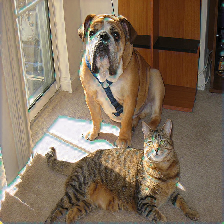

block_9_expand


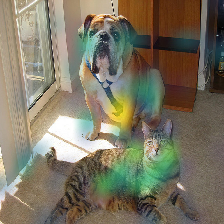

Conv_1


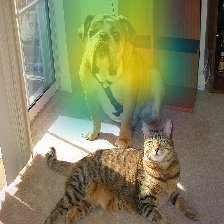

In [17]:
for l in ['block_1_expand', 'block_9_expand', 'Conv_1']:
    print(l)
    display(eli5.show_prediction(model, doc, layer=l)) # we pass the layer as an argument

For the cat:

block_1_expand


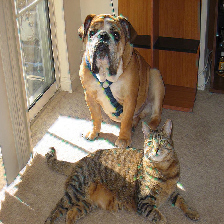

block_9_expand


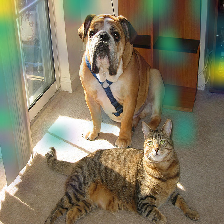

Conv_1


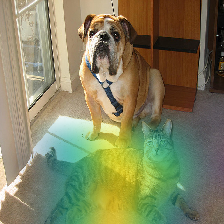

In [18]:
"""Cat"""
for l in ['block_1_expand', 'block_9_expand', 'Conv_1']:
    print(l)
    display(eli5.show_prediction(model, doc, layer=l, targets=[cat_idx])) # we pass the layer as an argument